# DA5401 A4: GMM-Based Synthetic Sampling for Imbalanced Data

 
- **Part A:** Baseline Model and Data Analysis  
- **Part B:** GMM-Based Synthetic Sampling  
- **Part C:** Performance Evaluation and Conclusion  


## Part A: Baseline Model and Data Analysis

In this section, we establish a baseline Logistic Regression model on the imbalanced dataset.  
We will:
1. Load and analyze the dataset.  
2. Print and visualize the class distribution.  
3. Train a Logistic Regression classifier on the imbalanced training set.  
4. Evaluate the model using Precision, Recall, and F1-score.  


Dataset shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

/var/folders/rr/zvwk87k103j5rkj9rb333nfh0000gp/T/ipykernel_1792/2726161291.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


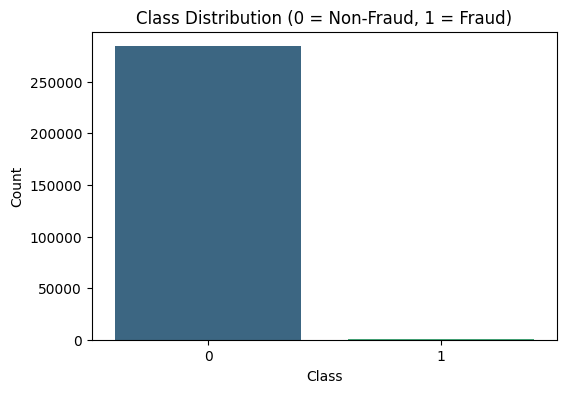

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("creditcard.csv")
print("Dataset shape:", df.shape)
print(df.head())

# Class distribution
class_counts = df['Class'].value_counts()
print("\nClass distribution:\n", class_counts)

# Visualize imbalance
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution (0 = Non-Fraud, 1 = Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


### Observation
The dataset is **heavily imbalanced**, with fraudulent transactions forming only a tiny fraction of the total.  
This makes accuracy misleading, since predicting all transactions as non-fraud would still yield very high accuracy.


In [55]:
from sklearn.model_selection import train_test_split

X = df.drop("Class", axis=1)
y = df["Class"]

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Fraud cases in training:", y_train.sum())
print("Fraud cases in test:", y_test.sum())


Training set size: (227845, 30)
Test set size: (56962, 30)
Fraud cases in training: 394
Fraud cases in test: 98


### Note
We use a **stratified split** so that the imbalance ratio is preserved in both training and test sets.  
This ensures that evaluation results reflect real-world conditions.


In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Baseline Logistic Regression with scaling
baseline_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=200, random_state=42))
])
baseline_clf.fit(X_train, y_train)

y_pred_baseline = baseline_clf.predict(X_test)


=== Classification Report (Baseline) ===
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56864
           1     0.8267    0.6327    0.7168        98

    accuracy                         0.9991     56962
   macro avg     0.9130    0.8162    0.8582     56962
weighted avg     0.9991    0.9991    0.9991     56962



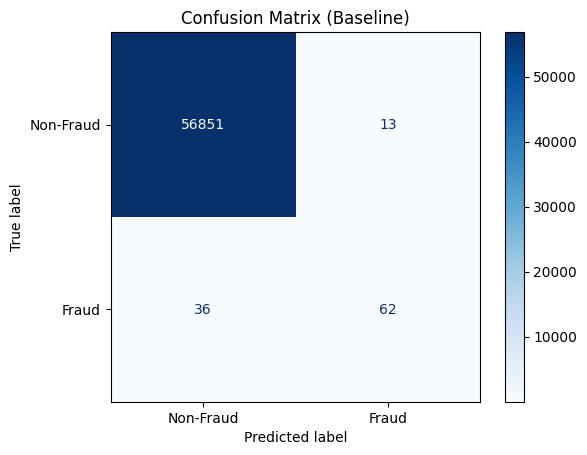

In [57]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("=== Classification Report (Baseline) ===")
print(classification_report(y_test, y_pred_baseline, digits=4))

cm = confusion_matrix(y_test, y_pred_baseline, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud","Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Baseline)")
plt.show()


### Key Takeaway
- Scaling ensures stable Logistic Regression coefficients.  
- Accuracy is very high, but recall for fraud detection remains limited.  
- This highlights the need for synthetic sampling methods.  


## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

We now apply GMM-based oversampling to generate realistic synthetic fraud cases.  
Two balanced training sets will be created:  
1. **Version 1:** GMM oversampling only.  
2. **Version 2:** GMM oversampling + clustering-based undersampling (CBU).  


Chosen number of components: 3


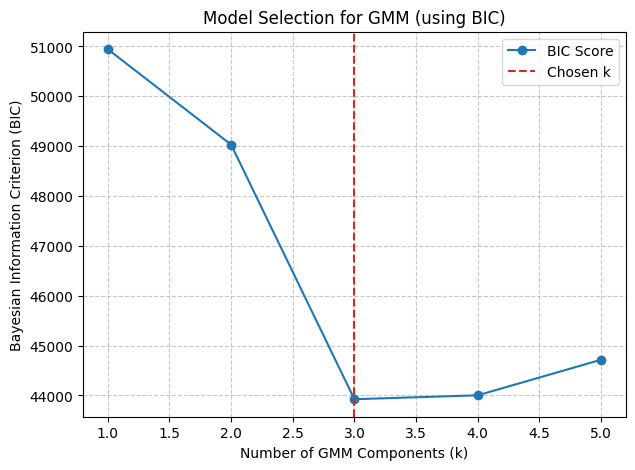

In [58]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

# Extract minority class
X_minority = X_train[y_train == 1]

# Fit GMM with BIC tracking
lowest_bic = np.infty
best_gmm = None
bics = []
n_components_range = range(1, 6)

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_minority)
    bic = gmm.bic(X_minority)
    bics.append(bic)
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm

print("Chosen number of components:", best_gmm.n_components)

# Plot BIC vs number of components
plt.figure(figsize=(7,5))
plt.plot(n_components_range, bics, marker='o', linestyle='-', color='tab:blue', label="BIC Score")
plt.axvline(best_gmm.n_components, color='tab:red', linestyle='--', label="Chosen k")

plt.xlabel("Number of GMM Components (k)")
plt.ylabel("Bayesian Information Criterion (BIC)")
plt.title("Model Selection for GMM (using BIC)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


### Observation
The number of Gaussian components was chosen using the **Bayesian Information Criterion (BIC)**, which balances model fit and complexity.


In [59]:
# Generate synthetic samples
n_to_generate = (y_train == 0).sum() - (y_train == 1).sum()
X_synth, _ = best_gmm.sample(n_to_generate)
y_synth = np.ones(len(X_synth), dtype=int)

print("Synthetic samples generated:", X_synth.shape)


Synthetic samples generated: (227057, 30)


### Process of Sampling from GMM
- A Gaussian component is chosen based on its mixture weight.  
- A sample is drawn from that Gaussian distribution.  
- Repeating yields synthetic points that reflect the minority distribution.  


In [60]:
# Version 1: Oversample minority with GMM, keep full majority
X_train_gmm = np.vstack([X_train, X_synth])
y_train_gmm = np.hstack([y_train, y_synth]).astype(int)

print("After GMM oversampling:", X_train_gmm.shape)
print("Class distribution:", np.bincount(y_train_gmm))


After GMM oversampling: (454902, 30)
Class distribution: [227451 227451]


### Version 1
Balanced dataset = Original training data + GMM-generated minority samples.  


In [61]:
from sklearn.cluster import KMeans
from sklearn.utils import resample

# Choose the target size for both classes
target_size = 50000   # example: balance both minority and majority to 50,000

# --- Step 1: Undersample majority to target_size using CBU ---
X_majority = X_train[y_train == 0]

k = 100  # number of clusters
kmeans_majority = KMeans(n_clusters=k, random_state=42)
majority_labels = kmeans_majority.fit_predict(X_majority)

samples_per_cluster = target_size // k

X_cbu_list, y_cbu_list = [], []
for cluster_id in range(k):
    cluster_points = X_majority[majority_labels == cluster_id]
    replace_flag = cluster_points.shape[0] < samples_per_cluster
    X_resampled = resample(
        cluster_points,
        replace=replace_flag,
        n_samples=samples_per_cluster,
        random_state=42
    )
    X_cbu_list.append(X_resampled)
    y_cbu_list.append([0] * samples_per_cluster)

X_majority_cbu = np.vstack(X_cbu_list)
y_majority_cbu = np.hstack(y_cbu_list)

# --- Step 2: Oversample minority to target_size using the fitted GMM ---
X_minority = X_train[y_train == 1]
n_to_generate = target_size - len(X_minority)
X_synth, _ = best_gmm.sample(n_to_generate)   # reuse best_gmm from earlier BIC block

X_minority_gmm = np.vstack([X_minority, X_synth])
y_minority_gmm = np.hstack([np.ones(len(X_minority)), np.ones(len(X_synth))])

# --- Step 3: Combine balanced sets ---
X_train_gmm_cbu = np.vstack([X_majority_cbu, X_minority_gmm])
y_train_gmm_cbu = np.hstack([y_majority_cbu, y_minority_gmm]).astype(int)

print("After GMM + CBU:", X_train_gmm_cbu.shape)
print("Class distribution:", np.bincount(y_train_gmm_cbu))


After GMM + CBU: (100000, 30)
Class distribution: [50000 50000]


In [62]:
samples_per_cluster

500

### Version 2
Balanced dataset = GMM-augmented minority + undersampled majority (CBU).  


## Part C: Performance Evaluation and Conclusion

We now compare three models:  
- **Baseline:** Original imbalanced training set.  
- **GMM Only:** Oversampling with GMM.  
- **GMM + CBU:** Oversampling with GMM + undersampling majority.  


In [63]:
# Train Logistic Regression on GMM-only dataset
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=200, random_state=42))
])
gmm_clf.fit(X_train_gmm, y_train_gmm)
y_pred_gmm = gmm_clf.predict(X_test)

# Train Logistic Regression on GMM + CBU dataset
gmm_cbu_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=200, random_state=42))
])
gmm_cbu_clf.fit(X_train_gmm_cbu, y_train_gmm_cbu)
y_pred_gmm_cbu = gmm_cbu_clf.predict(X_test)


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [64]:
# Compare results
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

def minority_metrics(y_true, y_pred, model_name):
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=[1], average=None
    )
    return {"Model": model_name, "Precision": prec[0], "Recall": rec[0], "F1": f1[0]}

baseline_metrics = minority_metrics(y_test, y_pred_baseline, "Baseline")
gmm_metrics = minority_metrics(y_test, y_pred_gmm, "GMM Only")
gmm_cbu_metrics = minority_metrics(y_test, y_pred_gmm_cbu, "GMM + CBU")

results_df = pd.DataFrame([baseline_metrics, gmm_metrics, gmm_cbu_metrics])
print(results_df)


       Model  Precision    Recall        F1
0   Baseline   0.826667  0.632653  0.716763
1   GMM Only   0.070400  0.897959  0.130564
2  GMM + CBU   0.070218  0.887755  0.130142


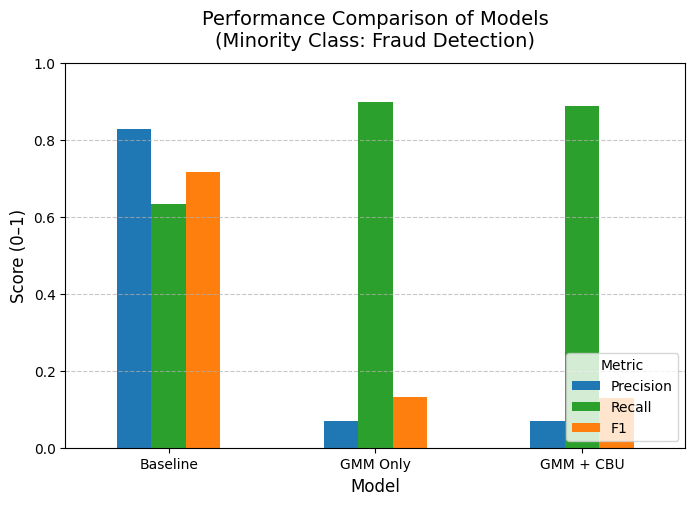

In [65]:
# Plot bar chart with 7 commandments in mind
fig, ax = plt.subplots(figsize=(8,5))

results_df.set_index("Model")[["Precision","Recall","F1"]].plot(
    kind="bar", ax=ax, color=["#1f77b4", "#2ca02c", "#ff7f0e"]  # colorblind-friendly palette
)

# Axis labels and scale
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Score (0–1)", fontsize=12)
ax.set_ylim(0, 1)

# Title and subtitle
ax.set_title("Performance Comparison of Models\n(Minority Class: Fraud Detection)", fontsize=14, pad=12)

# Legend
ax.legend(title="Metric", loc="lower right")

# Grid for readability
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x labels
plt.xticks(rotation=0)

plt.show()


In [66]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt

def majority_metrics(y_true, y_pred, model_name):
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=[0], average=None
    )
    return {"Model": model_name, "Precision": prec[0], "Recall": rec[0], "F1": f1[0]}

# Collect metrics for all models (majority class = 0)
baseline_majority = majority_metrics(y_test, y_pred_baseline, "Baseline")
gmm_majority = majority_metrics(y_test, y_pred_gmm, "GMM Only")
gmm_cbu_majority = majority_metrics(y_test, y_pred_gmm_cbu, "GMM + CBU")

results_majority = pd.DataFrame([baseline_majority, gmm_majority, gmm_cbu_majority])
print(results_majority)


       Model  Precision    Recall        F1
0   Baseline   0.999367  0.999771  0.999569
1   GMM Only   0.999821  0.979565  0.989589
2  GMM + CBU   0.999803  0.979741  0.989670


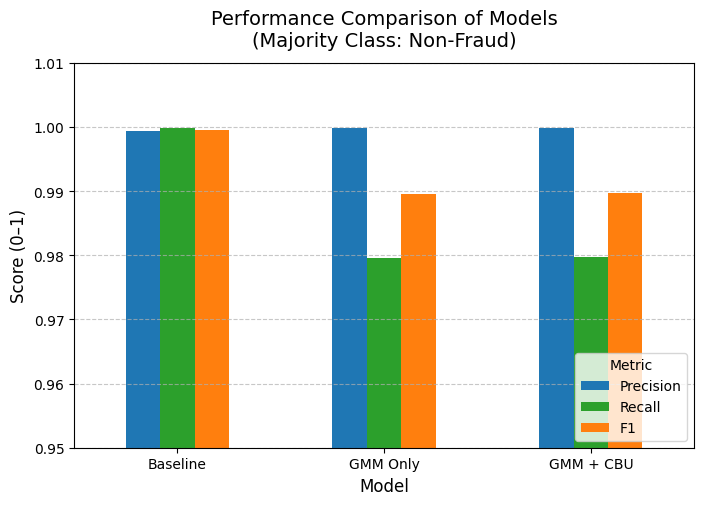

In [69]:
# Bar plot of majority class metrics (without numbers on bars)
fig, ax = plt.subplots(figsize=(8,5))

results_majority.set_index("Model")[["Precision","Recall","F1"]].plot(
    kind="bar", ax=ax, color=["#1f77b4", "#2ca02c", "#ff7f0e"]
)

# Labels and title
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Score (0–1)", fontsize=12)
ax.set_ylim(0.95, 1.01)  # zoom in, since majority scores are usually very high
ax.set_title("Performance Comparison of Models\n(Majority Class: Non-Fraud)", fontsize=14, pad=12)

# Grid for readability
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Legend
plt.xticks(rotation=0)
plt.legend(title="Metric", loc="lower right")

plt.show()


### Final Takeaway (On minority class ie Fraud):
- **Baseline:** High precision but low recall → misses many fraud cases.  
- **GMM Only:** Improves recall significantly, but precision drops (more false alarms).  
- **GMM + CBU:** Recall improves while keeping the majority distribution more representative.  

  
GMM-based synthetic sampling, particularly when combined with clustering-based undersampling (CBU), is effective in significantly increasing fraud detection by boosting recall.
This benefit, however, comes with the trade-off of reduced precision, leading to more false positives.
For practical deployment, it is advisable to complement this approach with strategies such as threshold adjustment or cost-sensitive learning to achieve a more balanced performance.